In [1]:
!conda activate rdkit
import pandas as pd #data table manipulation
from rdkit import Chem # basic cheminformatics
from rdkit.Chem.Descriptors import MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors
import math #needed for log10
import seaborn as sns #plotting
from sklearn.tree import DecisionTreeClassifier, plot_tree # decision trees
from sklearn.model_selection import train_test_split # split a dataset
from tqdm import tqdm # progress bar
from matplotlib import pyplot as plt # plotting
from dtreeviz.trees import * #plotting decision trees
from sklearn.metrics import roc_auc_score, matthews_corrcoef, cohen_kappa_score, plot_roc_curve, plot_confusion_matrix # model stats
from tdc.single_pred import ADME
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.rdBase import BlockLogs



In [2]:
def calc_descriptors(mol):
    if mol:
        Chem.DeleteSubstructs(mol, Chem.MolFromSmarts("[#1X0]"))
        mw, logp, num_arom_rings, hbd, hba = [x(mol) for x in [MolWt, MolLogP, NumAromaticRings, NumHDonors, NumHAcceptors]]
        res = [mw, logp, num_arom_rings, hbd, hba]
    else:
        res = [None] * 5
    return res

def standardize(smiles):
    # Code borrowed from https://bitsilla.com/blog/2021/06/standardizing-a-molecule-using-rdkit/
    # follows the steps in
    # https://github.com/greglandrum/RSC_OpenScience_Standardization_202104/blob/main/MolStandardize%20pieces.ipynb
    # as described **excellently** (by Greg) in
    # https://www.youtube.com/watch?v=eWTApNX8dJQ
    mol = Chem.MolFromSmiles(smiles)
     
    # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
    clean_mol = rdMolStandardize.Cleanup(mol) 
     
    # if many fragments, get the "parent" (the actual mol we are interested in) 
    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
         
    # try to neutralize molecule
    uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
     
    # note that no attempt is made at reionization at this step
    # nor at ionization at some pH (rdkit has no pKa caculator)
    # the main aim to to represent all molecules from different sources
    # in a (single) standard way, for use in ML, catalogue, etc.
     
    te = rdMolStandardize.TautomerEnumerator() # idem
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
     
    return taut_uncharged_parent_clean_mol

In [3]:
tqdm.pandas()
sol_df = pd.read_csv("data/soldata.csv")
block = BlockLogs()
sol_df['mol'] = sol_df.SMILES.progress_apply(standardize)
del block

sol_df['desc'] = sol_df.mol.progress_apply(calc_descriptors)
desc_cols = ['MW','LogP','NumAromatic','HBD','HBA']
sol_df[desc_cols] = sol_df.desc.to_list()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9982/9982 [00:03<00:00, 2628.85it/s]


In order to build a machine learning model, we will split the data into training and test sets. By default, the function train_test_split from scikit_learn puts 80% of the data into the training set and 20% into the test set. 

Our data is currently in a Pandas dataframe. I find it easier to build models with X and y variables. We'll split the training and test sets into X and y variables.


In [4]:
train, test = train_test_split(sol_df,test_size=0.2)
train_X = train[desc_cols]
train_y = train.IsSol
test_X = test[desc_cols]
test_y = test.IsSol

Create and train a classifier

In [5]:
#Create and train a classifier

cls = DecisionTreeClassifier(max_depth=4)
cls.fit(train_X,train_y)

DecisionTreeClassifier(max_depth=4)

Predict on the test set

In [6]:
pred = cls.predict(test_X)
auc, mcc, kappa = roc_auc_score(test_y, pred),matthews_corrcoef(test_y,pred),cohen_kappa_score(test_y,pred)
print(f"ROC AUC = {auc:.2f}")
print(f"Matthews Correlation Coefficient = {mcc:.2f}")
print(f"Cohen\'s Kappa = {kappa:.2f}")

ROC AUC = 0.83
Matthews Correlation Coefficient = 0.66
Cohen's Kappa = 0.66


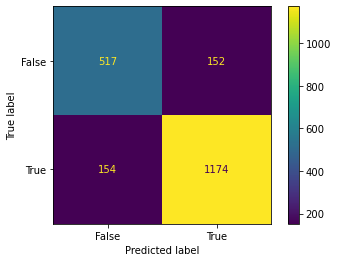

In [7]:
#Plot a confusion matrix to show the classifier performance
plot_confusion_matrix(cls,test_X,test_y)

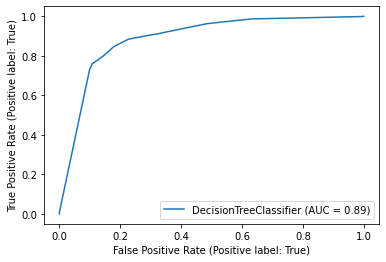

In [8]:
#Plot an ROC cure to show the classifier performance

plot_roc_curve(cls,test_X,test_y)

[Text(0.5446428571428571, 0.9, 'LogP <= 3.116\ngini = 0.439\nsamples = 7985\nvalue = [2600, 5385]'),
 Text(0.2857142857142857, 0.7, 'LogP <= 2.683\ngini = 0.222\nsamples = 5502\nvalue = [701, 4801]'),
 Text(0.14285714285714285, 0.5, 'MW <= 311.385\ngini = 0.168\nsamples = 4892\nvalue = [453, 4439]'),
 Text(0.07142857142857142, 0.3, 'HBA <= 0.5\ngini = 0.132\nsamples = 4367\nvalue = [309, 4058]'),
 Text(0.03571428571428571, 0.1, 'gini = 0.362\nsamples = 388\nvalue = [92, 296]'),
 Text(0.10714285714285714, 0.1, 'gini = 0.103\nsamples = 3979\nvalue = [217, 3762]'),
 Text(0.21428571428571427, 0.3, 'LogP <= 1.136\ngini = 0.398\nsamples = 525\nvalue = [144, 381]'),
 Text(0.17857142857142858, 0.1, 'gini = 0.185\nsamples = 204\nvalue = [21, 183]'),
 Text(0.25, 0.1, 'gini = 0.473\nsamples = 321\nvalue = [123, 198]'),
 Text(0.42857142857142855, 0.5, 'MW <= 138.232\ngini = 0.483\nsamples = 610\nvalue = [248, 362]'),
 Text(0.35714285714285715, 0.3, 'NumAromatic <= 0.5\ngini = 0.255\nsamples = 40\n

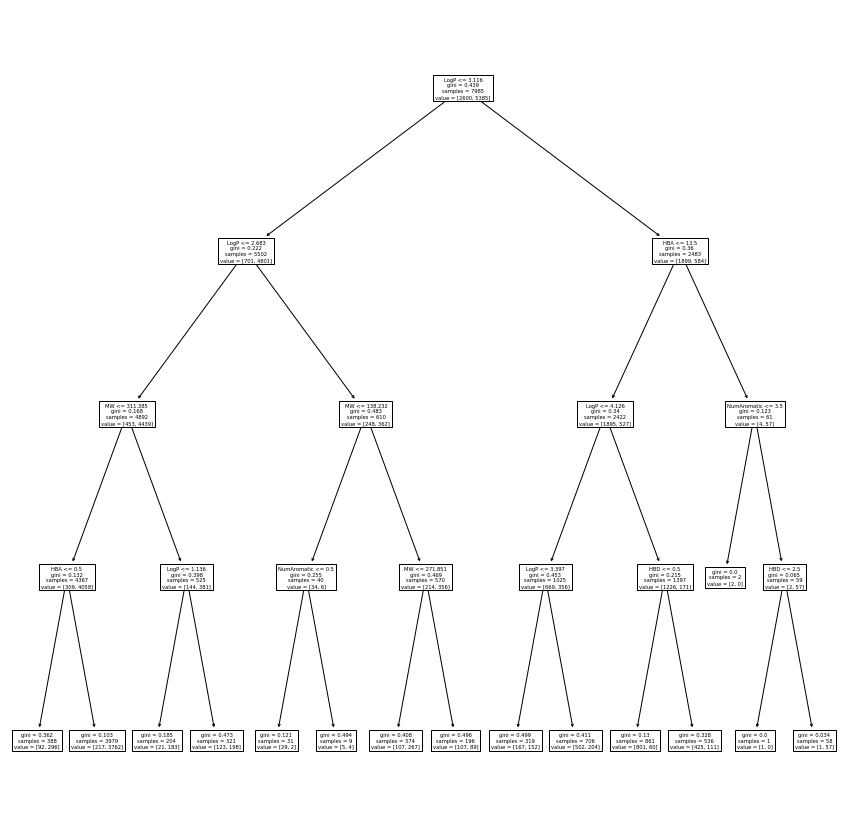

In [9]:
plt.rcParams["figure.figsize"] = (15,15)
plot_tree(cls,feature_names=desc_cols)

In [10]:
!pip install dtreeviz rdkit-pypi PyTDC

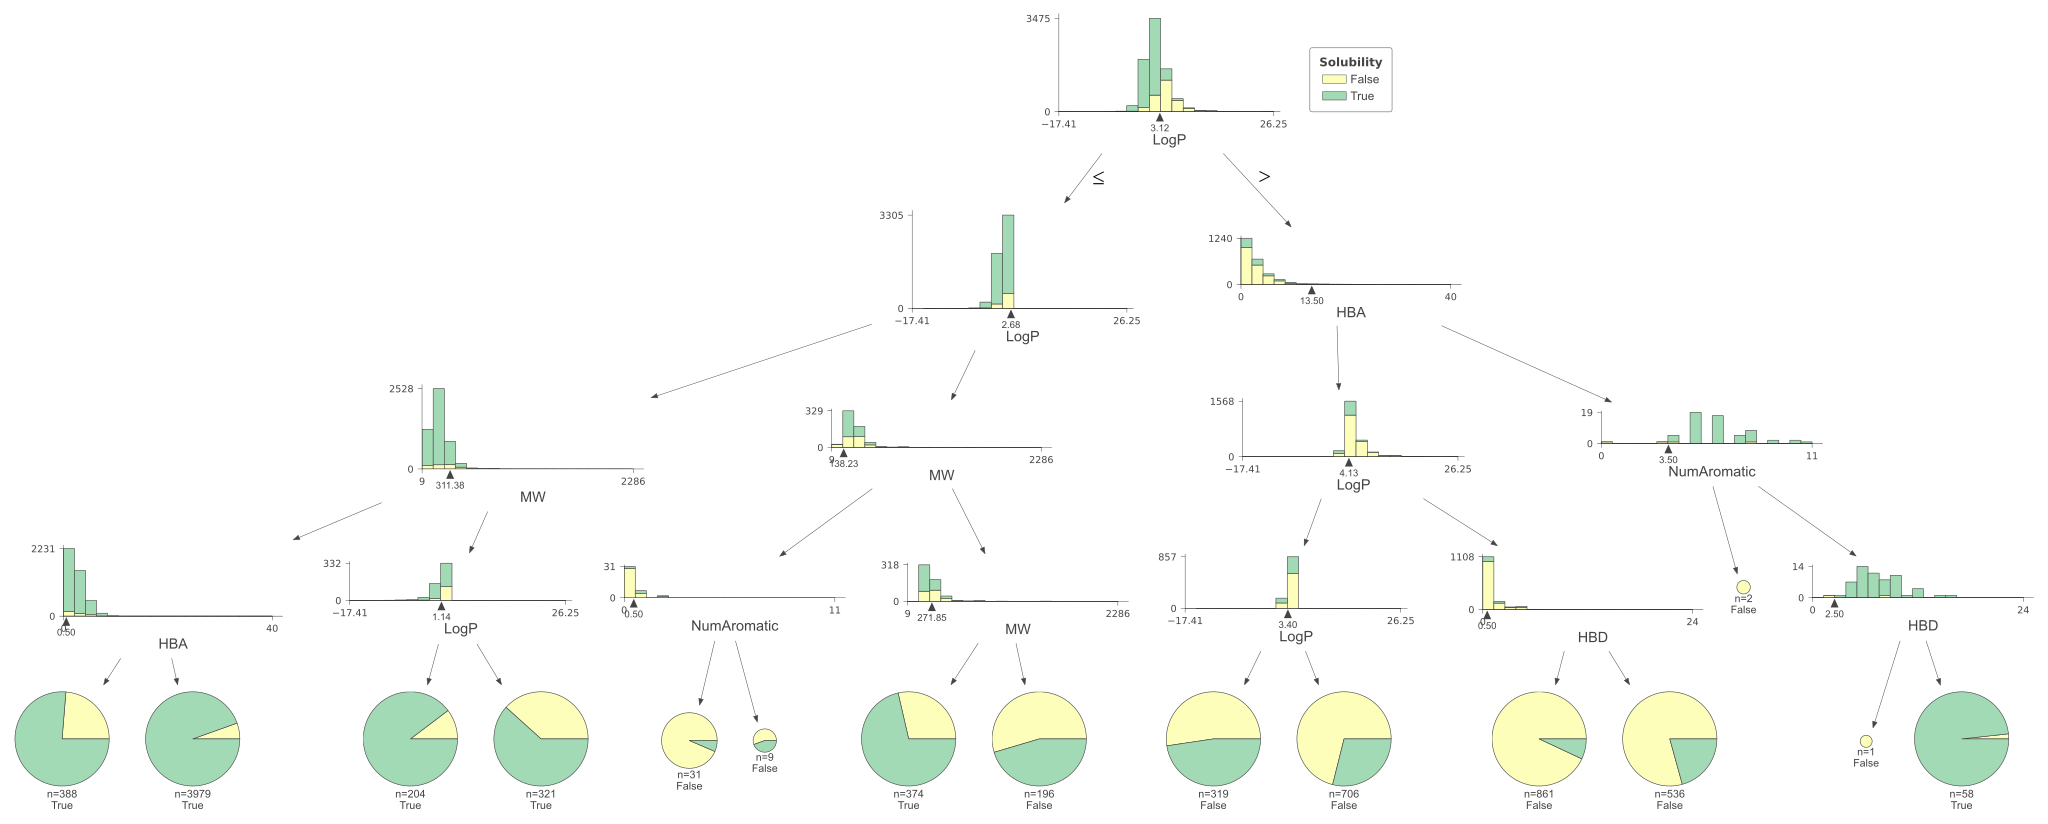

In [11]:
#Use dtreeviz to plot the decision tree
#!python -m pip install GraphViz
import os
os.environ["PATH"] += os.pathsep + "C:/Program Files/Graphviz/bin/dot.exe"

viz = dtreeviz(cls, train_X, train_y, feature_names = desc_cols, 
               target_name = "Solubility",class_names=["False","True"],scale=2)
viz

